In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
from transformers import get_scheduler
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

# new file
from rules_polypersonal import preprocess_texts


In [33]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=27)  # adjust num_labels as necessary

loading configuration file config.json from cache at /Users/clairepost/.cache/huggingface/hub/models--Llamacha--QuBERTa/snapshots/0f6c96c475e8ff91eba4bc73719aadf264de444e/config.json
Model config RobertaConfig {
  "_name_or_path": "Llamacha/QuBERTa",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading file vocab.json from cache at /Users/clairepost/.cache/huggingface/hub/models--Llamacha--QuBERTa/snapshots

In [34]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [35]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers


In [36]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    
    for dialect, directory_path in directory_paths.items():
        print("dialect:", dialect)
        for filename in os.listdir(directory_path):
            if filename.endswith('.txt'):
                print("filename:", filename)
                file_path = os.path.join(directory_path, filename)
                
                with open(file_path, 'r', encoding='latin-1') as file:
                    text = file.read().strip()
                    text = remove_numbers(text)
                    
                    # Split the original text into chunks
                    chunks = split_document(text)
                    print("document is in", len(chunks), "chunks")
                    
                    # Process each chunk without any tags
                    for chunk in chunks:
                        encoded_text = tokenizer(
                            chunk,
                            truncation=True,
                            padding='max_length',
                            max_length=512,
                            return_tensors="pt"
                        )
                        input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                        attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                        
                        processed_data.append({
                            'input_ids': input_ids_list,
                            'attention_mask': attention_mask_list,
                            'labels': label_dict[dialect]
                        })
                        
    return processed_data


In [37]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [ ]:

# Define your directory paths correctly
directory_paths = {
    'inb': '../language_resources/all_data_new_bible_nov26/inb',
    'qub': '../language_resources/all_data_new_bible_nov26/qub',
    'quf': '../language_resources/all_data_new_bible_nov26/quf',
    'quh': '../language_resources/all_data_new_bible_nov26/quh',
    'quk': '../language_resources/all_data_new_bible_nov26/quk',
    'qul': '../language_resources/all_data_new_bible_nov26/qul',
    'qup': '../language_resources/all_data_new_bible_nov26/qup',
    'quw': '../language_resources/all_data_new_bible_nov26/quw',
    'qux': '../language_resources/all_data_new_bible_nov26/qux',
    'quy': '../language_resources/all_data_new_bible_nov26/quy',
    'quz': '../language_resources/all_data_new_bible_nov26/quz', 
    'qvc': '../language_resources/all_data_new_bible_nov26/qvc',
    'qve': '../language_resources/all_data_new_bible_nov26/qve',  
    'qvi': '../language_resources/all_data_new_bible_nov26/qvi',
    'qvh': '../language_resources/all_data_new_bible_nov26/qvh',
    'qvm': '../language_resources/all_data_new_bible_nov26/qvm',
    'qvn': '../language_resources/all_data_new_bible_nov26/qvn',
    'qvo': '../language_resources/all_data_new_bible_nov26/qvo',
    'qvs': '../language_resources/all_data_new_bible_nov26/qvs',
    'qvw': '../language_resources/all_data_new_bible_nov26/qvw',
    'qvz': '../language_resources/all_data_new_bible_nov26/qvz',
    'qwh': '../language_resources/all_data_new_bible_nov26/qwh',
    'qxl': '../language_resources/all_data_new_bible_nov26/qxl',
    'qxh': '../language_resources/all_data_new_bible_nov26/qxh',
    'qxn': '../language_resources/all_data_new_bible_nov26/qxn',
    'qxo': '../language_resources/all_data_new_bible_nov26/qxo',
    'qxr': '../language_resources/all_data_new_bible_nov26/qxr'
}


# go through loading & processing
processed_data = load_and_preprocess(directory_paths)

dialect: inb
filename: INBWBT_1JN.txt
document is in 11 chunks
filename: INBWBT_3JN.txt
document is in 2 chunks
filename: INBWBT_2TH.txt
document is in 5 chunks
filename: INBWBT_2TI.txt
document is in 9 chunks
filename: INBWBT_COL.txt
document is in 10 chunks
filename: INBWBT_1PE.txt
document is in 13 chunks
filename: INBWBT_HEB.txt
document is in 34 chunks
filename: INBWBT_2JN.txt
document is in 1 chunks
filename: INBWBT_EPH.txt
document is in 14 chunks
filename: INBWBT_MRK.txt
document is in 59 chunks
filename: INBWBT_TIT.txt
document is in 5 chunks
filename: INBWBT_1TI.txt
document is in 12 chunks
filename: INBWBT_1TH.txt
document is in 9 chunks
filename: INBWBT_LUK.txt
document is in 99 chunks
filename: INBWBT_PHP.txt
document is in 10 chunks
filename: INBWBT_2PE.txt
document is in 8 chunks
filename: INBWBT_REV.txt
document is in 50 chunks
filename: Sibundoy-Verbal-Art.txt
document is in 1 chunks
filename: INBWBT_JAS.txt
document is in 12 chunks
filename: INBWBT_JUD.txt
document is

In [39]:

# Create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)



In [40]:
# List to store accuracy per epoch
epoch_accuracy = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [41]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Increased epochs
    # per_device_train_batch_size=10,  # Slightly larger batch size - original
    per_device_train_batch_size=20,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [42]:
trainer.train()

***** Running training *****
  Num examples = 36107
  Num Epochs = 1
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 1806
  Number of trainable parameters = 83471643


  0%|          | 0/1806 [00:00<?, ?it/s]

{'loss': 3.2853, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.2173, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 3.1009, 'learning_rate': 3e-06, 'epoch': 0.02}
{'loss': 2.9598, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}
{'loss': 2.8695, 'learning_rate': 5e-06, 'epoch': 0.03}
{'loss': 2.4277, 'learning_rate': 6e-06, 'epoch': 0.03}
{'loss': 2.5284, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.3715, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.4317, 'learning_rate': 9e-06, 'epoch': 0.05}
{'loss': 2.303, 'learning_rate': 1e-05, 'epoch': 0.06}
{'loss': 2.1785, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.06}
{'loss': 2.2026, 'learning_rate': 1.2e-05, 'epoch': 0.07}
{'loss': 2.0104, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.07}
{'loss': 1.9679, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.08}
{'loss': 2.0643, 'learning_rate': 1.5e-05, 'epoch': 0.08}
{'loss': 1.7145, 'learni

***** Running Evaluation *****
  Num examples = 6372
  Batch size = 15


  0%|          | 0/425 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to ./results/checkpoint-1806
Configuration saved in ./results/checkpoint-1806/config.json


{'eval_loss': 0.025871215388178825, 'eval_accuracy': 0.9918392969240427, 'eval_f1': 0.9916467971748921, 'eval_precision': 0.9915742251928645, 'eval_recall': 0.9918392969240427, 'eval_runtime': 517.5035, 'eval_samples_per_second': 12.313, 'eval_steps_per_second': 0.821, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-1806/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1806 (score: 0.9918392969240427).


{'train_runtime': 15410.8309, 'train_samples_per_second': 2.343, 'train_steps_per_second': 0.117, 'train_loss': 0.4595567648993147, 'epoch': 1.0}


TrainOutput(global_step=1806, training_loss=0.4595567648993147, metrics={'train_runtime': 15410.8309, 'train_samples_per_second': 2.343, 'train_steps_per_second': 0.117, 'train_loss': 0.4595567648993147, 'epoch': 1.0})

Train the model then save the model path so it can be used for unclassified data

In [43]:
model_path = './models/neural_rules_3'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in ./models/neural_rules_3/config.json
Model weights saved in ./models/neural_rules_3/pytorch_model.bin
tokenizer config file saved in ./models/neural_rules_3/tokenizer_config.json
Special tokens file saved in ./models/neural_rules_3/special_tokens_map.json


('./models/neural_rules_3/tokenizer_config.json',
 './models/neural_rules_3/special_tokens_map.json',
 './models/neural_rules_3/vocab.json',
 './models/neural_rules_3/merges.txt',
 './models/neural_rules_3/added_tokens.json',
 './models/neural_rules_3/tokenizer.json')

In [44]:
def get_predictions(model, dataloader):
    model.eval()  # Put model in evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels


***** Running Prediction *****
  Num examples = 6372
  Batch size = 15


  0%|          | 0/425 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


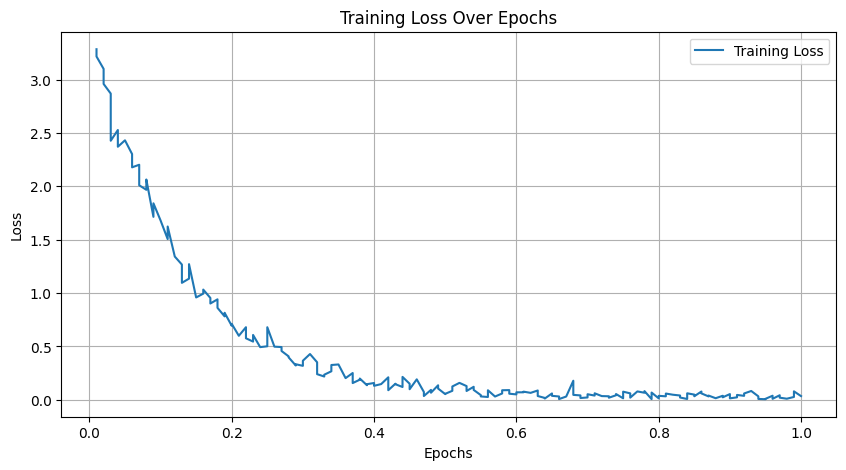

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()])
print("Classification Report:\n", report)


/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_24079/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_24079/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         inb       1.00      1.00      1.00       106
         qub       1.00      0.99      0.99       100
         quf       1.00      1.00      1.00       121
         quh       0.93      0.99      0.96       259
         quk       0.00      0.00      0.00         3
         qul       1.00      0.99      1.00       104
         qup       0.99      1.00      1.00       137
         quw       0.97      1.00      0.98        83
         qux       0.96      0.97      0.96       132
         quy       1.00      0.99      1.00       837
         quz       1.00      0.99      0.99      2081
         qvc       0.99      1.00      1.00       125
         qve       0.99      1.00      1.00       142
         qvi       1.00      1.00      1.00       115
         qvh       0.99      1.00      0.99        96
         qvm       0.99      0.99      0.99       104
         qvn       0.99      1.00      1.00       115
   

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

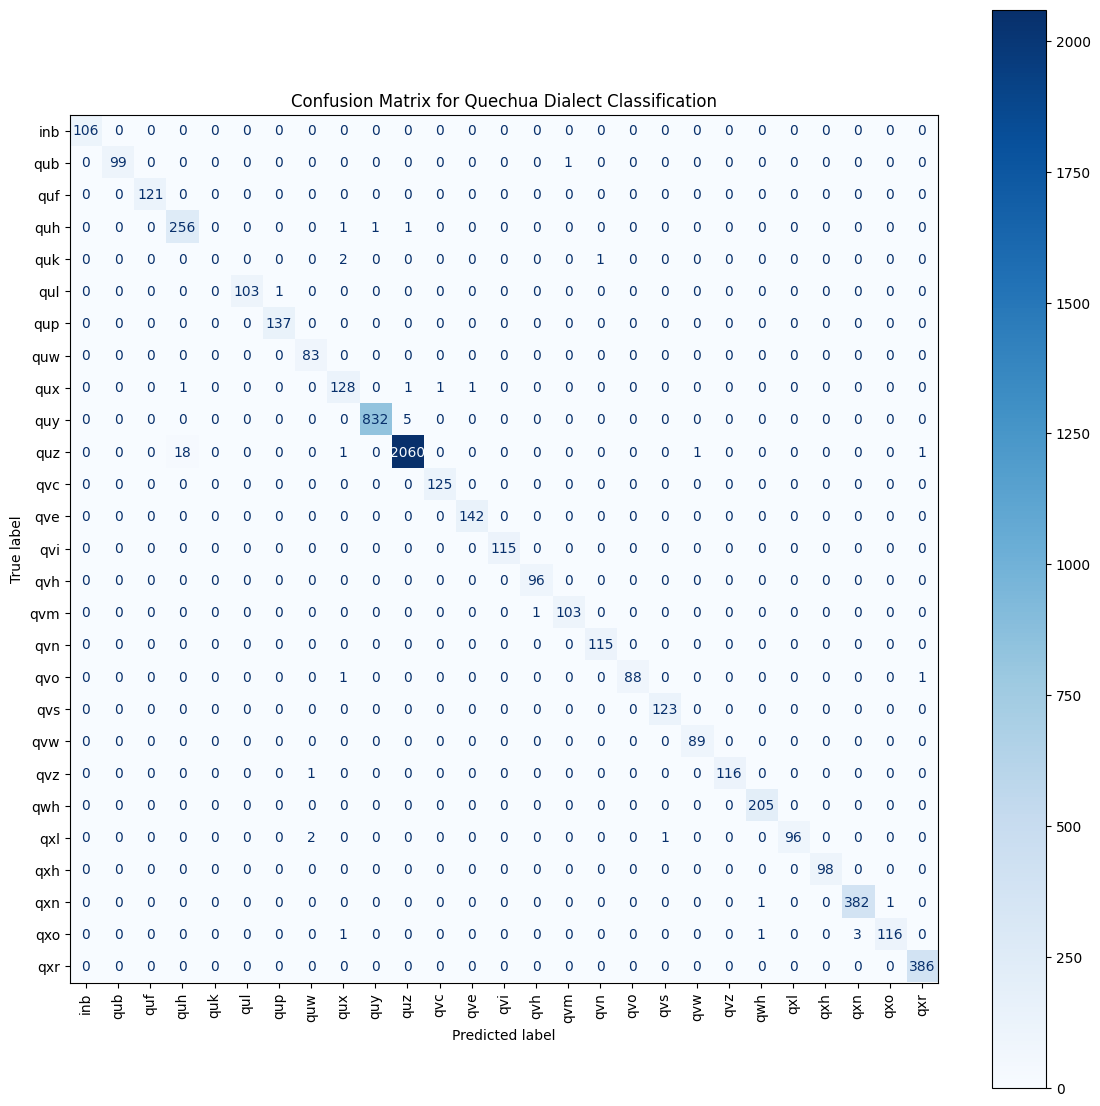

In [47]:
# Extract dialect names from the directory paths
dialect_labels = list(directory_paths.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Create a confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dialect_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as necessary for readability
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
ax.set_title('Confusion Matrix for Quechua Dialect Classification')
plt.show()

<Figure size 1000x700 with 0 Axes>

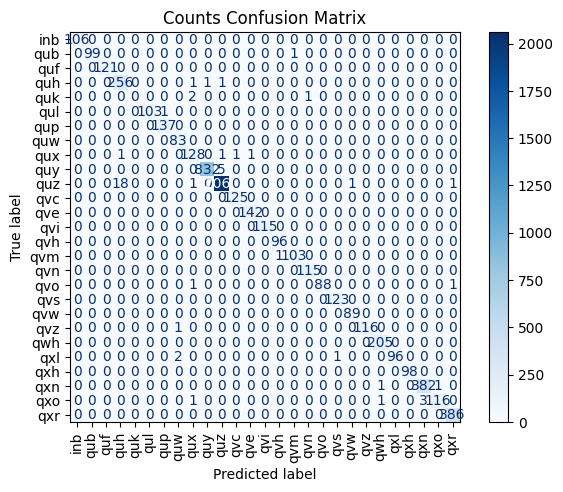

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout
plt.title("Counts Confusion Matrix")
plt.show()

Normalized Confusion Matrix

<Figure size 1000x700 with 0 Axes>

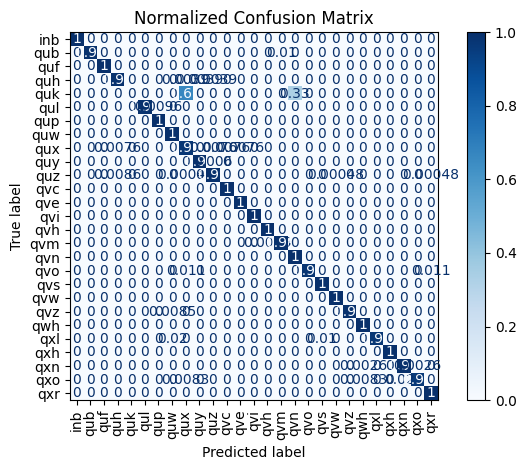

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adjust layout
plt.show()

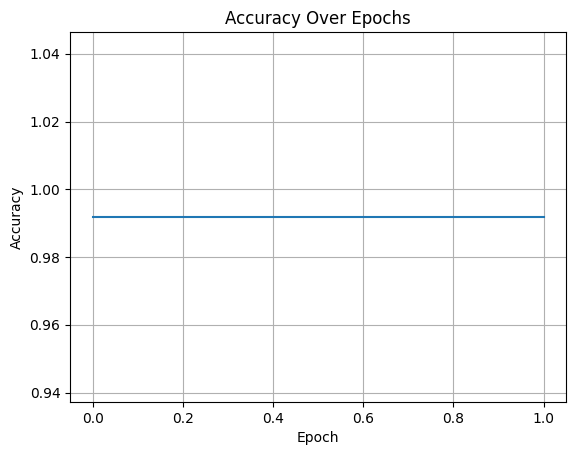

In [50]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

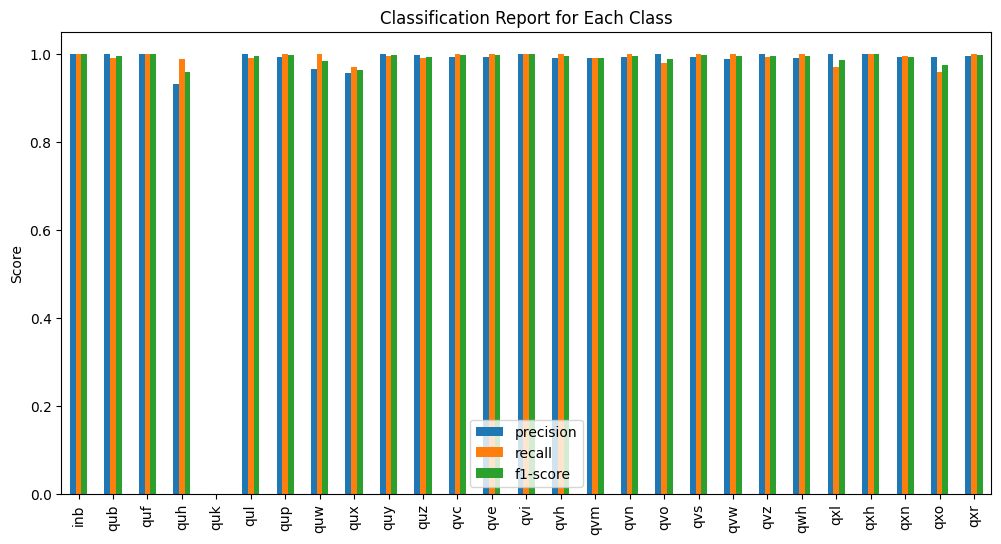

In [51]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(true_labels, predictions, target_names=directory_paths.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)  # Drop averages/total
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report for Each Class')
plt.ylabel('Score')
plt.show()
